In [1]:
%reload_ext autoreload
%autoreload 2

In [87]:
import io
import sys
import re
import copy
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from l2gx.align.utils import to_device
import networkx as nx
from scipy.stats import special_ortho_group
from umap import UMAP
import warnings
# Suppress common UMAP and sklearn warnings
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors, kneighbors_graph
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, SpectralClustering

# 🌌 <font color="grey"> Local2Global X - Graph Representation Learning at Scale</font>

#### <font color="grey">  Table of Contents</font>

🏗️ <a href='#chapter1'>Structure</a>

📊 <a href='#chapter2'>Datasets</a>

🌐 <a href='#chapter3'>Graphs</a>

🧩 <a href='#chapter4'>Patches</a>

🎯 <a href='#chapter5'>Embedding</a>

🔗 <a href='#chapter6'>Alignment</a>

🌳 <a href='#chapter7'>Hierarchical alignment</a>

📈 <a href='#chapter8'>Visualisation</a>

###  <a id='chapter1'> 🏗️ <font color="grey">Structure </font></a>

There are five main parts to the package, organised as follows.

```
l2gv2/
├── datasets/
├── graphs/
├── patch/
├── embedding/
└── align/
    ├── l2g/
    └── geo/
```

A brief overview of the contents:

* ```datasets``` contains interfaces are provided for various common benchmark datasets. 
* ```graphs``` contains wrappers for graphs represented as lists of edges in pytorch-geometric ```data.edge_index``` format. These implemented features such as fast adjacency look-up and a variety of algorithms on graphs.
* ```patch``` directory contains datastructures to represent patches and patch graphs, as well as methods to subdivide a graph into patches. 
* ```embedding``` contains various graph embedding methods, including Graph Autoencoders (GAE) and [Variational Graph Autoencoders (VGAE)](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.models.VGAE.html).
* ```align``` contains two methods to compute the alignment of patches into a single graph embedding: eigenvalue synchronisation based on the [Local2Global](https://link.springer.com/article/10.1007/s10994-022-06285-7) algorithm, and the new method based on learning the alignment using a one-layer neural network.

###  <a id='chapter2'> 📊 <font color="grey">Datasets </font></a>

The L2Gv2 framework provides access to multiple graph datasets spanning different domains and scales. All datasets are accessible through the unified `get_dataset()` interface and support conversion between multiple formats (PyTorch Geometric, Raphtory, Polars).

| Dataset | Type | Nodes | Edges | Features | Domain |
|---------|------|-------|-------|----------|--------|
| **Cora** | Static Citation | 2,708 | 10,556 | 1,433 | 📚 Academic Papers |
| **AS-733** | Temporal Network | 7,716 | 45,645 | Temporal | 🌐 Internet Infrastructure |
| **DGraph** | Financial | ~3M | ~4M | Multiple | 💰 Fraud Detection |
| **Elliptic** | Bitcoin | 203,769 | 234,355 | 166 | ₿ Cryptocurrency |
| **MAG240M** | Academic | 244M+ | 1.7B+ | Rich | 🎓 Citation Graph |
| **ORBITAAL** | Bitcoin Temporal | 252M (1K sample) | 785M (5K sample) | Temporal + Anomaly | ₿ Financial Fraud |

#### Dataset Details

* **Cora**: The [Cora dataset](https://graphsandnetworks.com/the-cora-dataset/) is a citation network of 2,708 scientific publications divided into 7 classes. Each node has a 1,433-dimensional feature vector indicating word presence/absence. Accessed through PyTorch Geometric's [Planetoid](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html) dataset.

* **AS-733**: The [SNAP autonomous systems AS-733](https://snap.stanford.edu/data/as-733.html) dataset contains 733 daily snapshots spanning 785 days (November 1997 to January 2000). Nodes represent autonomous systems and edges indicate communication events.

* **DGraph**: [DGraph](https://dgraph.xinye.com/dataset) is a real-world financial graph for anomaly detection research. Described in [DGraph: A Large-Scale Financial Dataset for Graph Anomaly Detection](https://arxiv.org/abs/2207.03579). Requires manual download.

* **Elliptic**: The [Elliptic dataset](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set) maps Bitcoin transactions to licit/illicit categories. Contains 203,769 transactions with 166 features each. Used in [Anti-Money Laundering in Bitcoin](https://arxiv.org/pdf/1908.02591) research. Requires manual download from Kaggle.

* **MAG240M**: The [MAG240M](https://ogb.stanford.edu/docs/lsc/mag240m/) dataset is a large heterogeneous academic citation graph with 244+ million nodes (papers, authors, institutions, fields) and 1.7+ billion edges. Requires the OGB library and substantial storage (~100GB).

* **ORBITAAL**: The [ORBITAAL](https://www.nature.com/articles/s41597-025-04595-8) dataset is a comprehensive temporal Bitcoin transaction graph covering 13 years (2009-2021) with 252M entities and 785M transactions. Features timestamped transactions, entity types (exchanges, wallets, services, miners), and anomaly labels for financial fraud detection. Ideal for temporal graph neural networks and cryptocurrency flow analysis.


For the datasets requiring manual download, provide the path:
```
elliptic = get_dataset("Elliptic", source_file="/path/to/elliptic.zip")
dgraph = get_dataset("DGraph", source_file="/path/to/dgraph.zip")
```

All datasets support conversion to different formats and follow the PyTorch Geometric convention. Temporal graphs return iterables over time slices, and graphs can be exported to Raphtory or NetworkX formats for analysis.

In [3]:
from l2gx.datasets import get_dataset, list_available_datasets
datasets = list_available_datasets()
print(datasets)

['as-733', 'Cora', 'DGraph', 'Elliptic', 'MAG240M', 'ORBITAAL']


In [4]:
cora = get_dataset("Cora")
print(cora[0])

Loading edge and node data from memory


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [10]:
# First transform data into raphtory format, then networkx for plotting.
G = cora.to("raphtory").to_networkx()
labels = cora[0].y.numpy()
print(f"Graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
print(f"Labels: {len(np.unique(labels))} unique classes")
class_names = ['Case_Based','Genetic_Algorithms', 'Neural_Networks','Probabilistic_Methods', 'Reinforcement_Learning','Rule_Learning', 'Theory']

Graph: 2708 nodes, 10556 edges
Labels: 7 unique classes


###  <a id='chapter3'> 🌐 <font color="grey">Graphs </font></a>

There are three wrappers for graphs that were taken over from the local2global package: ```TGraph```, ```NPGraph``` and ```JitGraph```. These include, among other things, methods for fast adjacency look-up and various optimizations. These are mostly used when performing graph clustering and generating patches.

In [28]:
from l2gx.graphs import TGraph

In [29]:
tg = TGraph(cora[0].edge_index, edge_attr=cora[0].edge_attr, x=cora[0].x)
print(tg.adj_index)
print(tg.x)

tensor([    0,     3,     6,  ..., 10548, 10552, 10556])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In a future iteration one can think about consolidating this part by having graphs represented in some existing graph package like Raphtory.

###  <a id='chapter4'> 🧩 <font color="grey">Patches </font></a>

A patch can equivalently refer to a subgraph or to an embedding of this subgraph. As a set of points, a patch is represented using the ```Patch``` class. A ```Patch``` object has the properties ```nodes```, ```index``` and ```coordinates```. ```nodes``` is simply a list of the nodes from the original graph that are present in the patch. ```index``` is a dict that maps each node to an index into ```coordinates```, which is just a list of coordinates. For example, if a graph embedding consists of four nodes in two dimensions as follows, and a patch is represented by the solid circles, then the corresponding object would have the following properties:

![Patch](./images/square_patch.png)


In [30]:
from l2gx.patch.patches import Patch

In [31]:
p = Patch([0,2,3], np.array([[0., 0.], [1., 0.], [1., 1.]]))
print(p.coordinates)
print(p.nodes)
print(p.index)

[[0. 0.]
 [1. 0.]
 [1. 1.]]
[0 2 3]
{0: 0, 2: 1, 3: 2}


In [45]:
from l2gx.patch.clustering.fennel import fennel_clustering
from l2gx.patch.clustering.metis import metis_clustering
from l2gx.patch import generate_patches

In [47]:
patches, patch_graph = generate_patches(tg, num_patches=10, clustering_method='metis')

Generating patches from graph with 2708 nodes, 10556 edges
Target patches: 10 → ~270 nodes per patch
Overlap: min=27, target=54
Step 1: Clustering with metis...
Clustering complete: 10 clusters, sizes: [260, 284]
Step 2: Creating patches with resistance sparsification...
number of patches: 10
average patch degree: 3.9


enlarging patch overlaps:   0%|          | 0/10 [00:00<?, ?it/s]

Patch generation complete: 10 patches created
Patch sizes: [305, 411], avg: 348.8


The patches from the nodes of a **patch graph**, where two nodes are connected by an edge if the patches contain overlapping nodes. The alignment tasks consists of making the correponding coordinates overlap as much as possible.

In [52]:
print([len(p.nodes) for p in patches])

[360, 305, 324, 411, 357, 346, 332, 351, 378, 324]


In [53]:
patches[0].coordinates

###  <a id='chapter5'> 🎯 <font color="grey">Embedding </font></a>

The L2GX framework implements several graph embedding methods: ```SVDEmbedding```, ```GAEEmbedding```, ```VGAEEmbedding```, ```GraphSAGEEmbedding``` and ```DGIEmbedding```. The first three are based on transductive learning, while the last two are inductive.

* <font color="grey">SVD</font> - Classical spectral approach using eigendecomposition
* <font color="grey">GAE</font> - [Graph Auto-Encoder ](https://arxiv.org/abs/1611.07308) for deterministic reconstruction
* <font color="grey">VGAE</font> - [Variational Graph Auto-Encoder](https://arxiv.org/abs/1611.07308) with probabilistic latent variables
* <font color="grey">GraphSAGE</font> - [Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216) for scalable embedding
* <font color="grey">DGI</font> - [Deep Graph Infomax](https://arxiv.org/abs/1809.10341) using self-supervised contrastive learning

All methods are accessible through a unified interface with the ```get_embedding()``` function and registry system. The demonstration below shows convergence analysis, quality metrics, and UMAP visualizations for comprehensive comparison.

In [54]:
from l2gx.embedding import get_embedding

In [55]:
print("📚 Loading Cora dataset...")
cora_data = cora[0]
print(f"Cora dataset: {cora_data.num_nodes} nodes, {cora_data.num_edges} edges")
print(f"Node features: {cora_data.x.shape}")
print(f"Classes: {cora_data.y.unique().numel()}")
print()

📚 Loading Cora dataset...
Cora dataset: 2708 nodes, 10556 edges
Node features: torch.Size([2708, 1433])
Classes: 7



In [56]:
embedding_methods = ['svd', 'gae', 'vgae', 'dgi', 'graphsage']
embeddings = {}
embedding_times = {}
training_histories = {}  # Store loss histories for each method

# Function to capture and parse training output
def capture_training_output(func, *args, **kwargs):
    """Capture stdout and parse training loss values."""
    old_stdout = sys.stdout
    sys.stdout = captured_output = io.StringIO()
    
    try:
        result = func(*args, **kwargs)
        output = captured_output.getvalue()
    finally:
        sys.stdout = old_stdout
    
    # Parse loss values from output using regex
    loss_pattern = r'Epoch\s+(\d+),\s+Loss:\s+([\d.]+)'
    matches = re.findall(loss_pattern, output)
    
    if matches:
        epochs = [int(match[0]) for match in matches]
        losses = [float(match[1]) for match in matches]
        # Print the captured output so user can still see it
        print(output, end='')
        return result, (epochs, losses)
    else:
        print(output, end='')
        return result, None

for method in embedding_methods:
    print(f"🔄 Computing {method} embedding...")
    start_time = time.time()
    
    try:
        if method == 'svd':
            # SVD embedding (spectral approach) - no iterative training
            embedder = get_embedding(method, embedding_dim=64)
            embeddings[method] = embedder.fit_transform(cora_data)
            training_histories[method] = None  # SVD doesn't have iterative training
            
        elif method == 'gae':
            # Graph Auto-Encoder with loss tracking
            embedder = get_embedding(method, embedding_dim=64, num_epochs=200)
            result, loss_data = capture_training_output(embedder.fit_transform, cora_data)
            embeddings[method] = result
            if loss_data:
                epochs, losses = loss_data
                training_histories[method] = {'epochs': epochs, 'losses': losses}
            else:
                training_histories[method] = None
                
        elif method == 'vgae':
            # Variational Graph Auto-Encoder with loss tracking
            embedder = get_embedding(method, embedding_dim=64, num_epochs=200)
            result, loss_data = capture_training_output(embedder.fit_transform, cora_data)
            embeddings[method] = result
            if loss_data:
                epochs, losses = loss_data
                training_histories[method] = {'epochs': epochs, 'losses': losses}
            else:
                training_histories[method] = None
                
        elif method == 'dgi':
            # Deep Graph Infomax with loss tracking
            embedder = get_embedding(method, embedding_dim=64, num_epochs=200)
            result, loss_data = capture_training_output(embedder.fit_transform, cora_data)
            embeddings[method] = result
            if loss_data:
                epochs, losses = loss_data
                training_histories[method] = {'epochs': epochs, 'losses': losses}
            else:
                training_histories[method] = None
                
        elif method == 'graphsage':
            # GraphSAGE inductive embedding with loss tracking
            embedder = get_embedding(method, embedding_dim=64, num_epochs=200)
            result, loss_data = capture_training_output(embedder.fit_transform, cora_data)
            embeddings[method] = result
            if loss_data:
                epochs, losses = loss_data
                training_histories[method] = {'epochs': epochs, 'losses': losses}
            else:
                training_histories[method] = None
        
        end_time = time.time()
        embedding_times[method] = end_time - start_time
        
        print(f"✅ {method} embedding completed in {embedding_times[method]:.2f}s")
        print(f"   Embedding shape: {embeddings[method].shape}")
        
        # Print training info if available
        if training_histories[method] is not None:
            losses = training_histories[method]['losses']
            epochs = training_histories[method]['epochs']
            print(f"   Captured {len(losses)} loss values from epochs {epochs[0]} to {epochs[-1]}")
            print(f"   Initial loss: {losses[0]:.4f}, Final loss: {losses[-1]:.4f}")
        
    except Exception as e:
        print(f"❌ {method} embedding failed: {str(e)}")
        # Create a placeholder embedding for visualization
        embeddings[method] = torch.randn(cora_data.num_nodes, 64)
        embedding_times[method] = 0.0
        training_histories[method] = None
    
    print()

print(f"📊 Embedding computation summary:")
for method, emb in embeddings.items():
    print(f"   {method}: {emb.shape} ({embedding_times[method]:.2f}s)")
print()

🔄 Computing svd embedding...
✅ svd embedding completed in 0.05s
   Embedding shape: (2708, 64)

🔄 Computing gae embedding...
Epoch 000, Loss: 1.3570
Epoch 050, Loss: 1.0048
Epoch 100, Loss: 0.9542
Epoch 150, Loss: 0.9415
✅ gae embedding completed in 2.48s
   Embedding shape: (2708, 64)
   Captured 4 loss values from epochs 0 to 150
   Initial loss: 1.3570, Final loss: 0.9415

🔄 Computing vgae embedding...
Epoch 000, Loss: 6.7758
Epoch 050, Loss: 0.9077
Epoch 100, Loss: 0.8518
Epoch 150, Loss: 0.8551
✅ vgae embedding completed in 3.15s
   Embedding shape: (2708, 64)
   Captured 4 loss values from epochs 0 to 150
   Initial loss: 6.7758, Final loss: 0.8551

🔄 Computing dgi embedding...
Epoch 000, Loss: 1.3866
Epoch 050, Loss: 0.0997
Epoch 100, Loss: 0.0054
Epoch 150, Loss: 0.0025
Epoch 200, Loss: 0.0015
Epoch 250, Loss: 0.0013
✅ dgi embedding completed in 11.61s
   Embedding shape: (2708, 64)
   Captured 6 loss values from epochs 0 to 250
   Initial loss: 1.3866, Final loss: 0.0013

🔄 Co

📈 TRAINING CONVERGENCE ANALYSIS


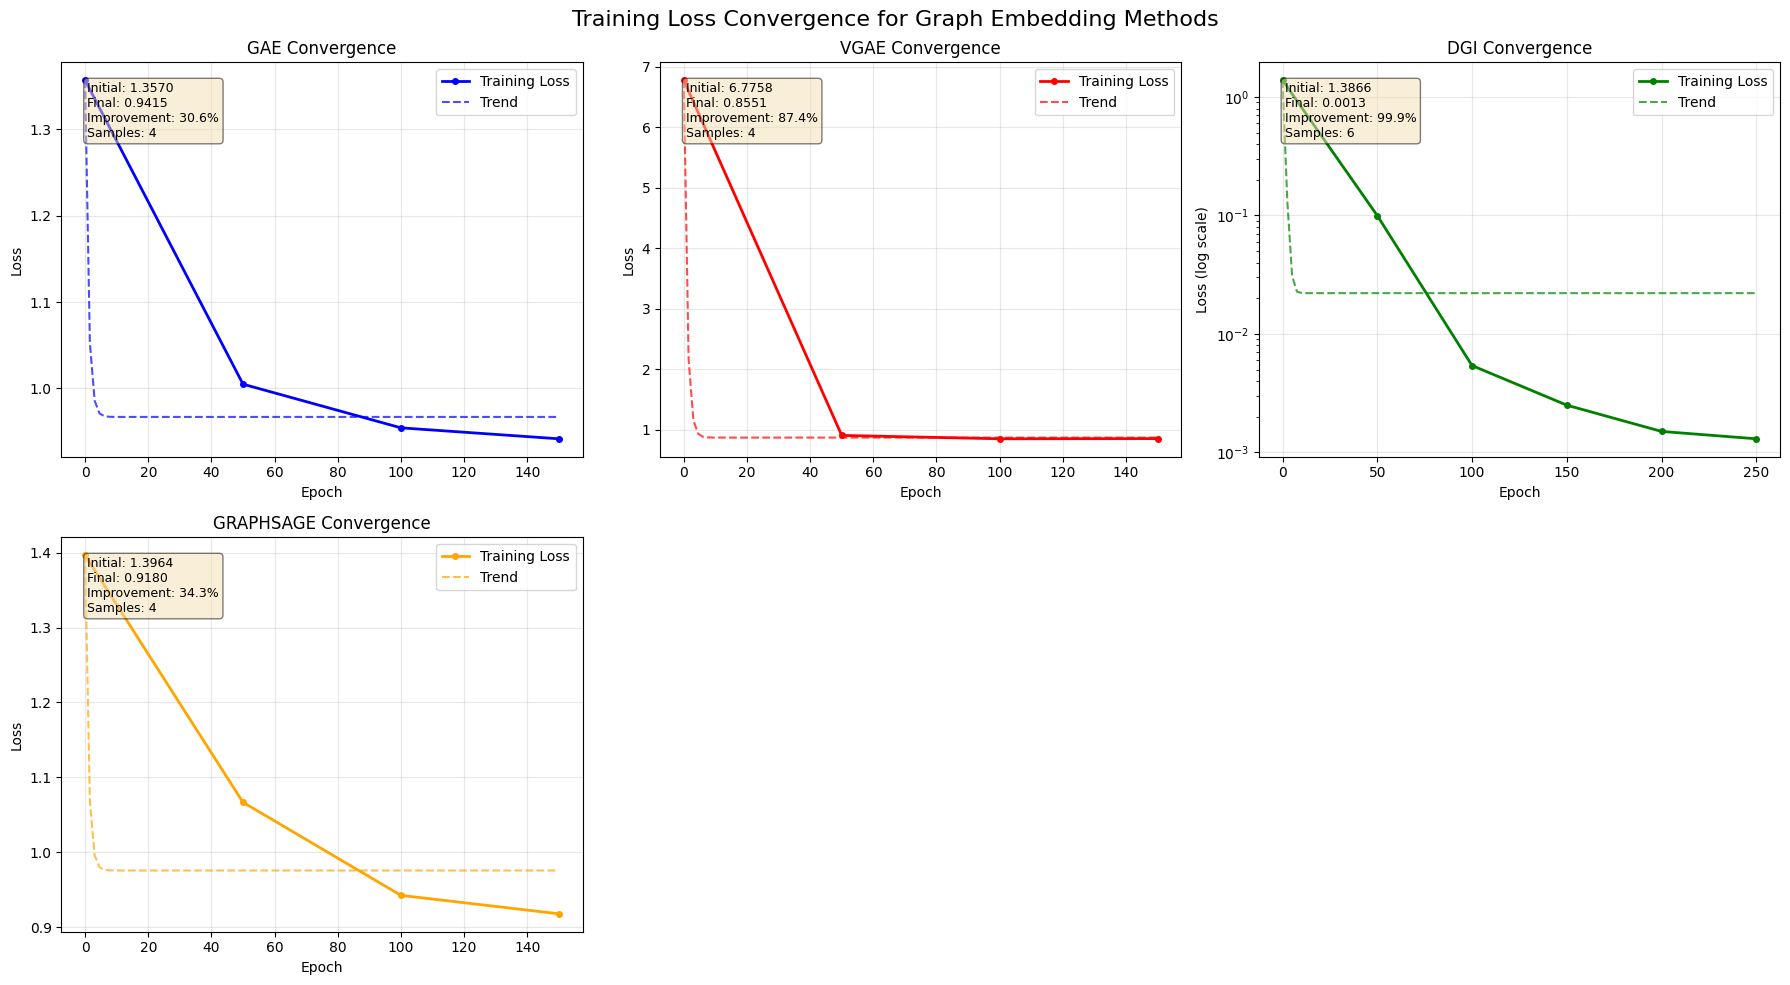

📊 Convergence Summary:
   Method      | Initial Loss | Final Loss | Improvement | Captured Points
   ------------|--------------|------------|-------------|----------------
   gae         |     1.3570   |   0.9415   |     30.6%    |             4
   vgae        |     6.7758   |   0.8551   |     87.4%    |             4
   dgi         |     1.3866   |   0.0013   |     99.9%    |             6
   graphsage   |     1.3964   |   0.9180   |     34.3%    |             4

📊 Detailed Convergence Metrics:
   GAE:
     • Convergence rate: 0.002752 loss/epoch
     • Final quarter stability (variance): 0.000000
     • Training span: epochs 0 to 150
   VGAE:
     • Convergence rate: 0.039210 loss/epoch
     • Final quarter stability (variance): 0.000000
     • Training span: epochs 0 to 150
   DGI:
     • Convergence rate: 0.005519 loss/epoch
     • Final quarter stability (variance): 0.000000
     • Training span: epochs 0 to 250
   GRAPHSAGE:
     • Convergence rate: 0.003168 loss/epoch
     • Fi

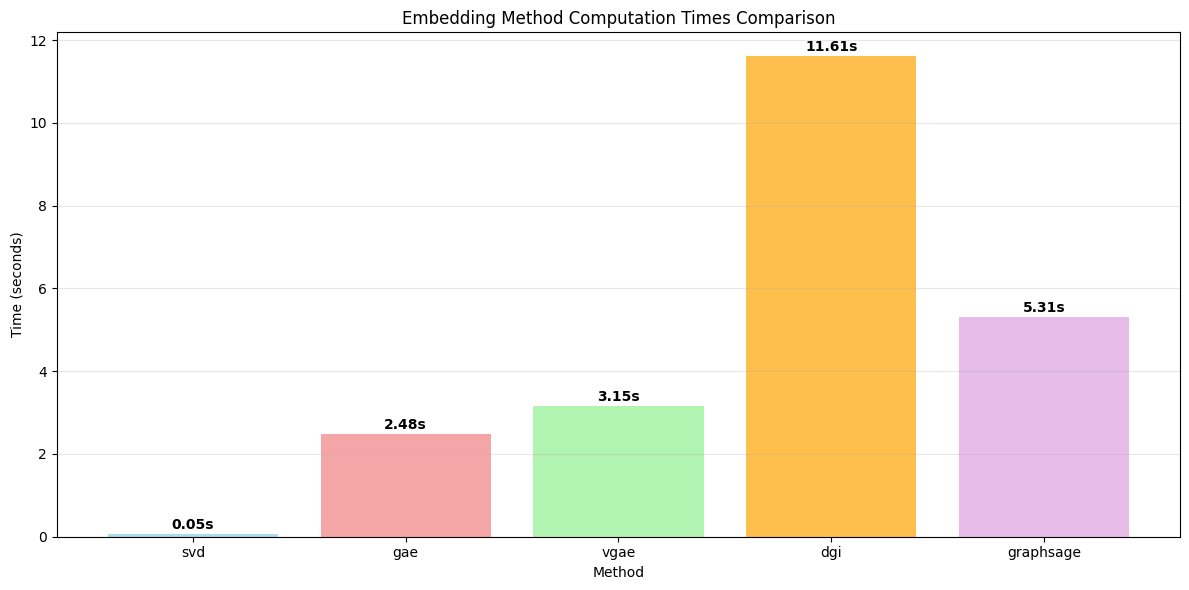


📈 Convergence Analysis:
   • Loss curves reveal optimization dynamics and training stability
   • GAE, VGAE: Reconstruction-based methods with different regularization
   • DGI: Self-supervised contrastive learning approach
   • GraphSAGE: Inductive method that can generalize to unseen nodes
   • SVD: Direct eigendecomposition method (no iterative training)
   • Steeper initial drops indicate faster convergence
   • Flat final regions suggest convergence to stable solutions



In [57]:
# Visualize Training Convergence
print("📈 TRAINING CONVERGENCE ANALYSIS")
print("=" * 60)

# Count methods with training histories
methods_with_history = [method for method in embedding_methods 
                       if training_histories[method] is not None]

if methods_with_history:
    # Create convergence plots with optimal layout
    n_methods = len(methods_with_history)
    
    if n_methods <= 2:
        # Single row for 1-2 methods
        fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))
        if n_methods == 1:
            axes = [axes]
    else:
        # Two rows for 3+ methods
        n_cols = min(3, n_methods)  # Max 3 columns
        n_rows = (n_methods + n_cols - 1) // n_cols  # Ceiling division
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
        # Flatten axes array for easier indexing
        if n_rows == 1:
            axes = axes if isinstance(axes, list) else [axes]
        else:
            axes = axes.flatten()
    
    fig.suptitle('Training Loss Convergence for Graph Embedding Methods', fontsize=16)
    
    # Color palette for different methods
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown']
    
    for idx, method in enumerate(methods_with_history):
        history_data = training_histories[method]
        epochs = history_data['epochs']
        losses = history_data['losses']
        color = colors[idx % len(colors)]
        
        # Plot training loss
        axes[idx].plot(epochs, losses, '-', color=color, linewidth=2, marker='o', 
                      markersize=4, label='Training Loss')
        axes[idx].set_title(f'{method.upper()} Convergence')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel('Loss')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].legend()
        
        # Add convergence statistics
        initial_loss = losses[0]
        final_loss = losses[-1]
        improvement = ((initial_loss - final_loss) / initial_loss) * 100
        
        # Add text box with statistics
        textstr = f'Initial: {initial_loss:.4f}\nFinal: {final_loss:.4f}\nImprovement: {improvement:.1f}%\nSamples: {len(losses)}'
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        axes[idx].text(0.05, 0.95, textstr, transform=axes[idx].transAxes, fontsize=9,
                      verticalalignment='top', bbox=props)
        
        # Log scale option for better visualization if loss varies greatly
        if max(losses) / min(losses) > 100:
            axes[idx].set_yscale('log')
            axes[idx].set_ylabel('Loss (log scale)')
        
        # Add trend line if we have enough points
        if len(losses) > 2:
            try:
                from scipy.optimize import curve_fit
                def exp_decay(x, a, b, c):
                    return a * np.exp(-b * x) + c
                
                popt, _ = curve_fit(exp_decay, epochs, losses, maxfev=1000)
                trend_epochs = np.linspace(min(epochs), max(epochs), 100)
                trend_losses = exp_decay(trend_epochs, *popt)
                axes[idx].plot(trend_epochs, trend_losses, '--', color=color, alpha=0.7, label='Trend')
                axes[idx].legend()
            except:
                pass  # Skip trend line if fitting fails
    
    # Hide empty subplots if we have more axes than methods
    if n_methods < len(axes):
        for idx in range(n_methods, len(axes)):
            axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics table
    print("📊 Convergence Summary:")
    print("   Method      | Initial Loss | Final Loss | Improvement | Captured Points")
    print("   ------------|--------------|------------|-------------|----------------")
    for method in methods_with_history:
        history_data = training_histories[method]
        losses = history_data['losses']
        epochs = history_data['epochs']
        initial = losses[0]
        final = losses[-1]
        improvement = ((initial - final) / initial) * 100
        n_points = len(losses)
        print(f"   {method:<11} | {initial:>10.4f}   | {final:>8.4f}   | {improvement:>8.1f}%    | {n_points:>13}")
    
    # Additional convergence metrics
    print()
    print("📊 Detailed Convergence Metrics:")
    for method in methods_with_history:
        history_data = training_histories[method]
        losses = history_data['losses']
        epochs = history_data['epochs']
        
        # Calculate convergence rate (loss reduction per epoch)
        if len(losses) > 1:
            total_epochs = epochs[-1] - epochs[0] + 1
            loss_reduction = losses[0] - losses[-1]
            convergence_rate = loss_reduction / total_epochs
            
            # Calculate stability (variance in final 25% of training)
            final_quarter = losses[int(0.75 * len(losses)):]
            stability = np.var(final_quarter)
            
            print(f"   {method.upper()}:")
            print(f"     • Convergence rate: {convergence_rate:.6f} loss/epoch")
            print(f"     • Final quarter stability (variance): {stability:.6f}")
            print(f"     • Training span: epochs {epochs[0]} to {epochs[-1]}")
            
else:
    print("ℹ️  No iterative training methods detected or loss tracking failed.")
    print("   SVD is a direct spectral method without iterative optimization.")

# Always show computation time comparison
print()
print("⏱️  COMPUTATION TIME COMPARISON")
print("=" * 60)

plt.figure(figsize=(12, 6))
methods_list = list(embedding_methods)
times_list = [embedding_times[method] for method in methods_list]

# Create color-coded bars
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'plum']
bars = plt.bar(methods_list, times_list, alpha=0.7, color=colors[:len(methods_list)])
plt.title('Embedding Method Computation Times Comparison')
plt.xlabel('Method')
plt.ylabel('Time (seconds)')
plt.grid(True, alpha=0.3, axis='y')

# Add time labels on bars
for bar, time_val in zip(bars, times_list):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{time_val:.2f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [58]:
# Prepare node labels for quality evaluation
node_labels = cora_data.y.numpy()

silhouette_scores = {}
for method in embedding_methods:
    if torch.is_tensor(embeddings[method]):
        embedding_np = embeddings[method].detach().numpy()
    else:
        embedding_np = embeddings[method]
    
    # Calculate silhouette score (higher is better)
    silhouette_scores[method] = silhouette_score(embedding_np, node_labels)

print("📊 Embedding Quality Metrics:")
print("   Method          | Silhouette Score | Computation Time")
print("   ----------------|------------------|------------------")
for method in embedding_methods:
    score = silhouette_scores[method]
    time_taken = embedding_times[method]
    print(f"   {method:<15} | {score:>13.3f}    | {time_taken:>13.2f}s")

print()
print("📈 Interpretation:")
print("   • Silhouette Score: Measures how well-separated the clusters are")
print("   • Higher scores indicate better embedding quality for classification")
print("   • Consider both quality and computation time for practical applications")
print()

# Highlight the best performing method
best_method = max(silhouette_scores.keys(), key=lambda k: silhouette_scores[k])
print(f"🏆 Best performing method: {best_method} (Silhouette Score: {silhouette_scores[best_method]:.3f})")
print()

📊 Embedding Quality Metrics:
   Method          | Silhouette Score | Computation Time
   ----------------|------------------|------------------
   svd             |        -0.072    |          0.05s
   gae             |         0.018    |          2.48s
   vgae            |         0.073    |          3.15s
   dgi             |         0.021    |         11.61s
   graphsage       |         0.123    |          5.31s

📈 Interpretation:
   • Silhouette Score: Measures how well-separated the clusters are
   • Higher scores indicate better embedding quality for classification
   • Consider both quality and computation time for practical applications

🏆 Best performing method: graphsage (Silhouette Score: 0.123)



🗺️  UMAP VISUALIZATION OF EMBEDDINGS
🔄 Creating UMAP visualization for svd...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


🔄 Creating UMAP visualization for gae...
🔄 Creating UMAP visualization for vgae...
🔄 Creating UMAP visualization for dgi...
🔄 Creating UMAP visualization for graphsage...


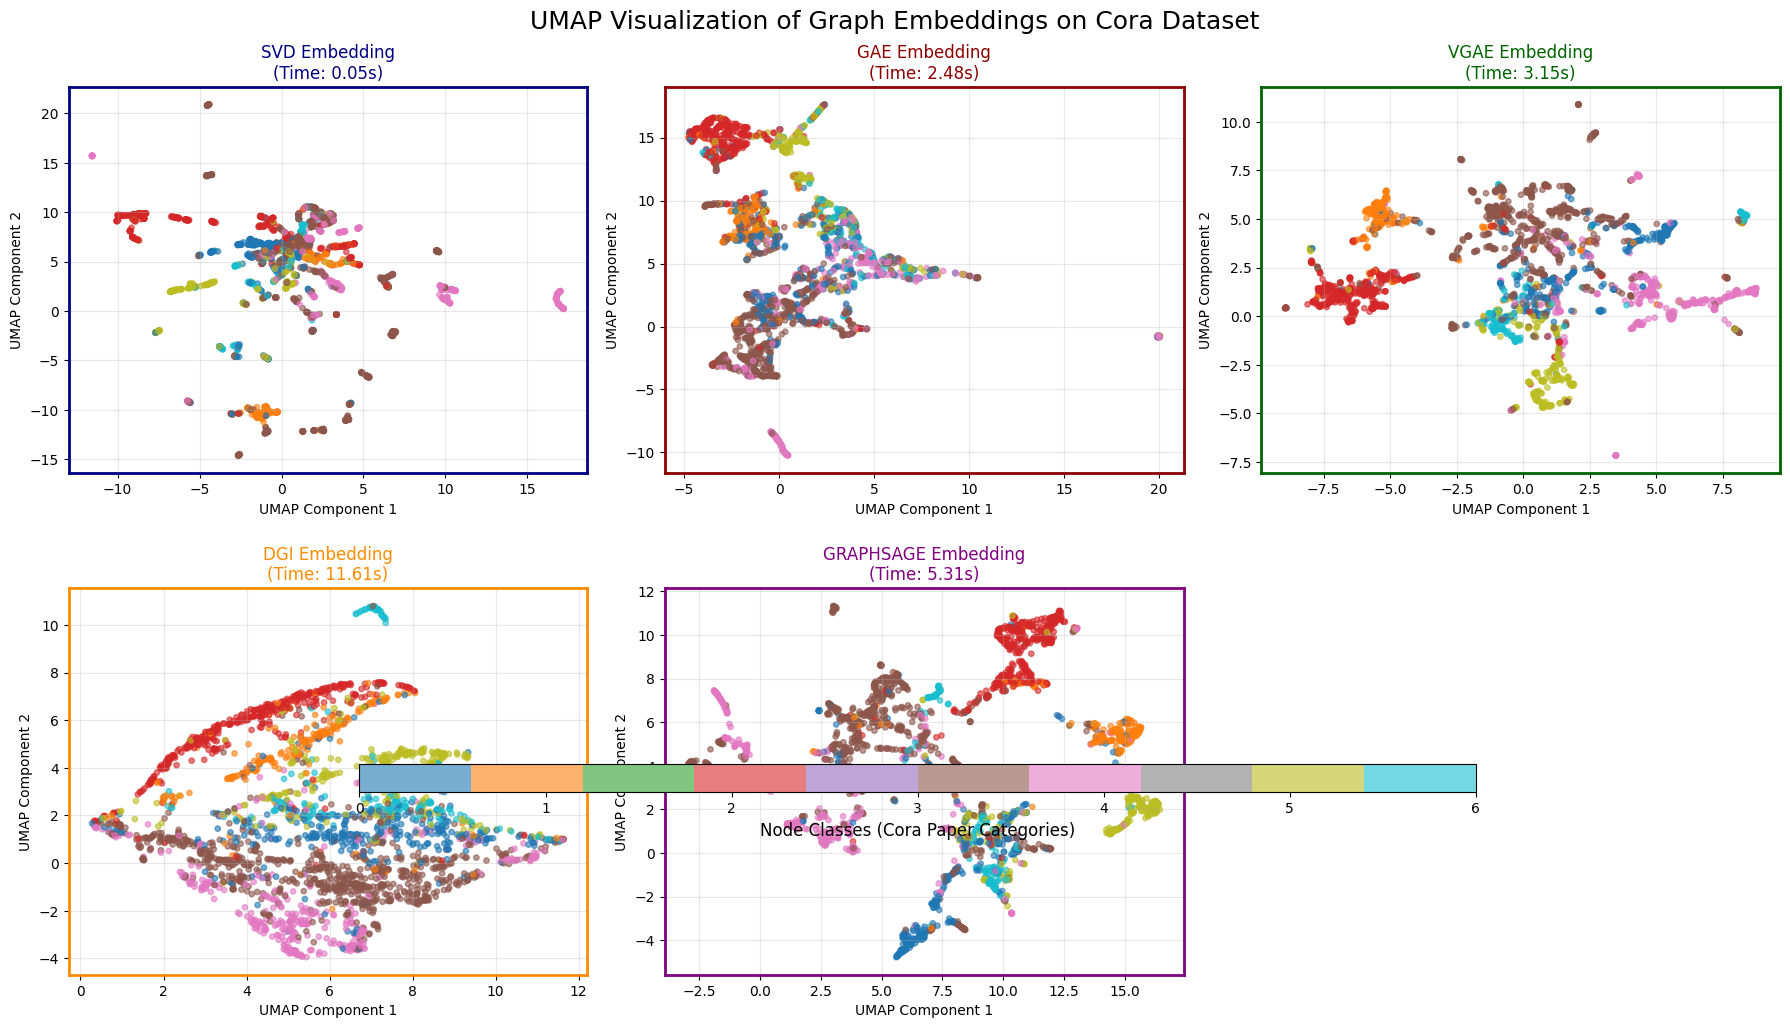

✅ UMAP visualizations completed!

📊 Comparative Visualization Analysis:
   • Each point represents a paper (node) in the Cora citation network
   • Colors indicate the 7 different research areas
   • SVD: Direct spectral embedding (fastest but may be less refined)
   • GAE/VGAE: Reconstruction-based embeddings (GAE deterministic, VGAE probabilistic)
   • DGI: Self-supervised contrastive learning (good for unsupervised tasks)
   • GraphSAGE: Inductive method (can embed new nodes without retraining)
   • Compare clustering quality to see which method best separates paper categories



In [59]:
print("🗺️  UMAP VISUALIZATION OF EMBEDDINGS")
print("=" * 60)

# Prepare node labels for coloring
node_labels = cora_data.y.numpy()
class_names = ['Case_Based', 'Genetic_Algorithms', 'Neural_Networks', 
               'Probabilistic_Methods', 'Reinforcement_Learning', 'Rule_Learning', 'Theory']

# Create UMAP visualizations with optimal layout for 5 methods
n_methods = len(embedding_methods)
n_cols = 3  # 3 columns
n_rows = (n_methods + n_cols - 1) // n_cols  # Ceiling division: 2 rows for 5 methods

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
axes = axes.flatten()  # Flatten for easier indexing

fig.suptitle('UMAP Visualization of Graph Embeddings on Cora Dataset', fontsize=18)

# Color palette for different methods
method_colors = ['navy', 'darkred', 'darkgreen', 'darkorange', 'purple']

for idx, method in enumerate(embedding_methods):
    print(f"🔄 Creating UMAP visualization for {method}...")
    
    # Convert embedding to numpy if it's a tensor
    if torch.is_tensor(embeddings[method]):
        embedding_np = embeddings[method].detach().numpy().astype(np.float32)
    else:
        embedding_np = np.array(embeddings[method], dtype=np.float32)
    
    # Ensure data is finite and normalized
    embedding_np = np.nan_to_num(embedding_np, nan=0.0, posinf=1.0, neginf=-1.0)
    
    # Apply UMAP for dimensionality reduction with robust parameters
    umap_model = UMAP(
        n_components=2, 
        random_state=42, 
        n_neighbors=min(15, len(embedding_np) - 1),  # Ensure n_neighbors < n_samples
        min_dist=0.1,
        metric='euclidean',
        n_jobs=1,  # Avoid threading warnings
        low_memory=False,
        verbose=False
    )
    
    embedding_2d = umap_model.fit_transform(embedding_np)
    
    # Create scatter plot
    scatter = axes[idx].scatter(embedding_2d[:, 0], embedding_2d[:, 1], 
                               c=node_labels, cmap='tab10', alpha=0.6, s=15)
    
    # Add method-specific styling
    axes[idx].set_title(f'{method.upper()} Embedding\n(Time: {embedding_times[method]:.2f}s)', 
                       fontsize=12, color=method_colors[idx % len(method_colors)])
    axes[idx].set_xlabel('UMAP Component 1')
    axes[idx].set_ylabel('UMAP Component 2')
    axes[idx].grid(True, alpha=0.3)
    
    # Add border color to distinguish methods
    for spine in axes[idx].spines.values():
        spine.set_edgecolor(method_colors[idx % len(method_colors)])
        spine.set_linewidth(2)

# Hide empty subplots
for idx in range(n_methods, len(axes)):
    axes[idx].set_visible(False)

# Add a single colorbar for all plots
cbar = fig.colorbar(scatter, ax=axes[:n_methods], orientation='horizontal', 
                   pad=0.05, aspect=40, shrink=0.8)
cbar.set_label('Node Classes (Cora Paper Categories)', fontsize=12)

plt.tight_layout()
plt.show()

# Re-enable warnings for subsequent code
warnings.resetwarnings()

###  <a id='chapter6'> 🔗 <font color="grey">Alignment </font></a>

In [181]:
from l2gx.align import get_aligner
from examples.example import (
    generate_points, 
    voronoi_patches, 
    plot_patches, 
    transform_patches
)
from l2gx.align import procrustes_error
rg = np.random.default_rng()

In [182]:
points = generate_points(n_clusters=5, scale=1.0, std=0.2, max_size=2000, min_size=128, dim=2)
patches, centers = voronoi_patches(points, sample_size=10, min_degree=4, min_overlap=64, min_patch_size=128, eps=1, kmeans=False)

In [183]:
noise_level = 0 # 0.1
shift_scale = 1
scale_range = None #[0.01, 100]

# Create transformed copies of the patches
transformed_patches = [copy.deepcopy(p) for p in patches]

# Add noise to the transformed patches
if noise_level > 0:
    for patch in transformed_patches:
        noise = rg.normal(loc=0, scale=noise_level, size=patch.coordinates.shape)
        patch.coordinates += noise

transformed_patches = transform_patches(
    transformed_patches, 
    shift_scale=shift_scale, 
    scale_range=scale_range
    )

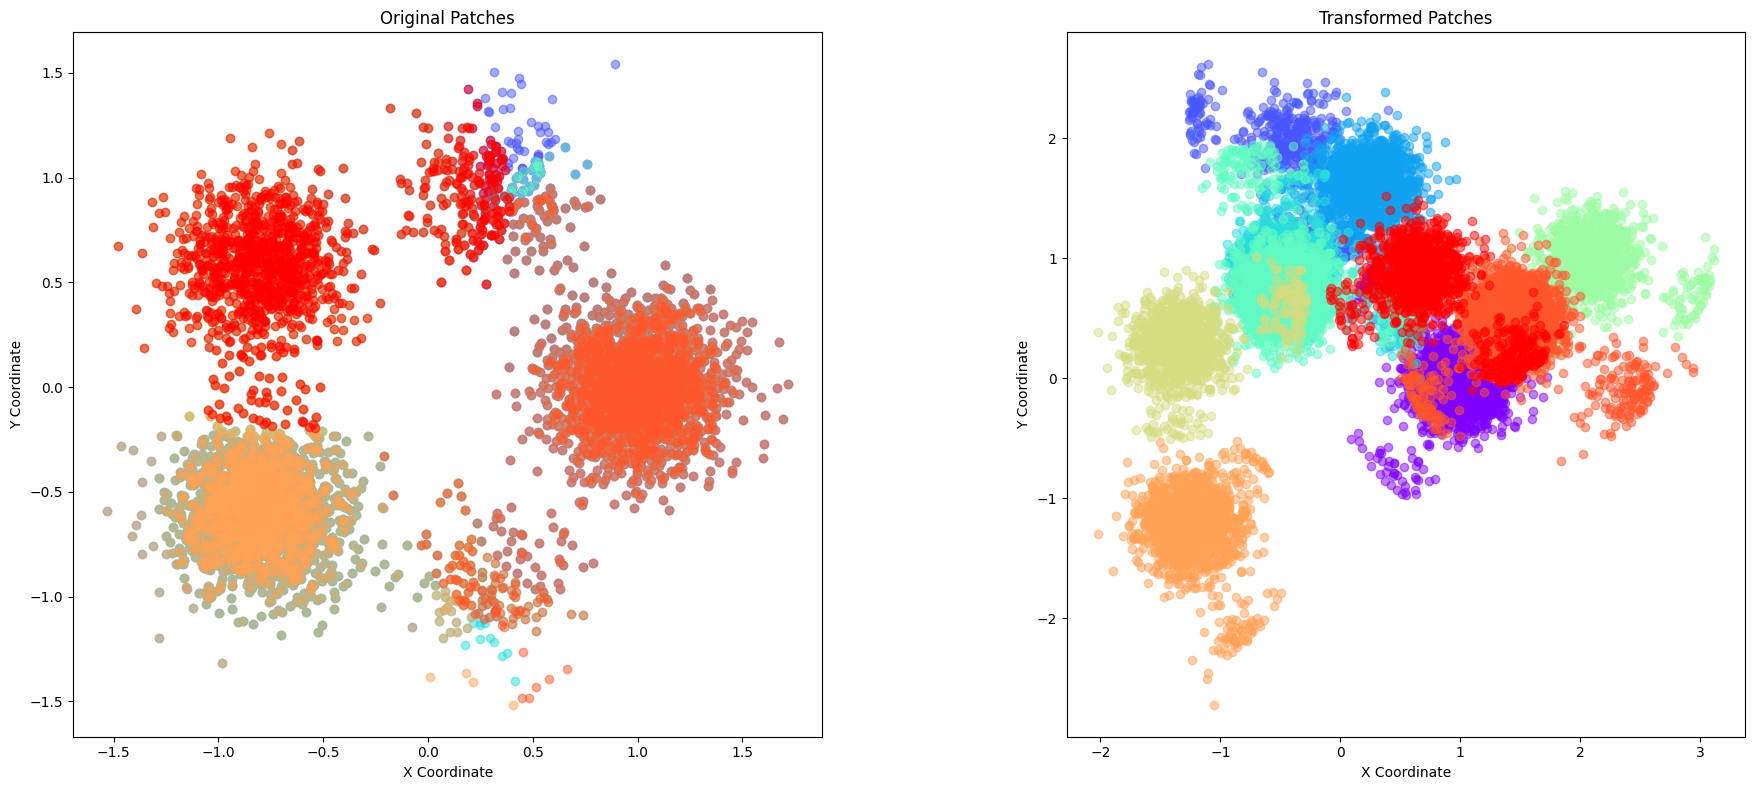

In [184]:
plot_patches(patches, transformed_patches)

mean patch degree: 5.4
Epoch 0, Loss: 10.788142204284668
Epoch 10, Loss: 6.680323123931885
Epoch 20, Loss: 3.8733227252960205
Epoch 30, Loss: 2.171626091003418
Epoch 40, Loss: 1.2106541395187378
Epoch 50, Loss: 0.6845463514328003
Epoch 60, Loss: 0.41007134318351746
Epoch 70, Loss: 0.27353164553642273
Epoch 80, Loss: 0.2044278383255005
Epoch 90, Loss: 0.16610194742679596
Epoch 100, Loss: 0.14190533757209778
Epoch 110, Loss: 0.12453402578830719
Epoch 120, Loss: 0.11077753454446793
Epoch 130, Loss: 0.09918852150440216
Epoch 140, Loss: 0.08907539397478104
Epoch 150, Loss: 0.08006969839334488
Epoch 160, Loss: 0.07195870578289032
Epoch 170, Loss: 0.06461106985807419
Epoch 180, Loss: 0.05793757736682892
Epoch 190, Loss: 0.051871418952941895
Epoch 200, Loss: 0.0463588573038578
Epoch 210, Loss: 0.04135417193174362
Epoch 220, Loss: 0.03681710362434387
Epoch 230, Loss: 0.03271113336086273
Epoch 240, Loss: 0.029002664610743523
Epoch 250, Loss: 0.025660371407866478
Epoch 260, Loss: 0.02265487983822

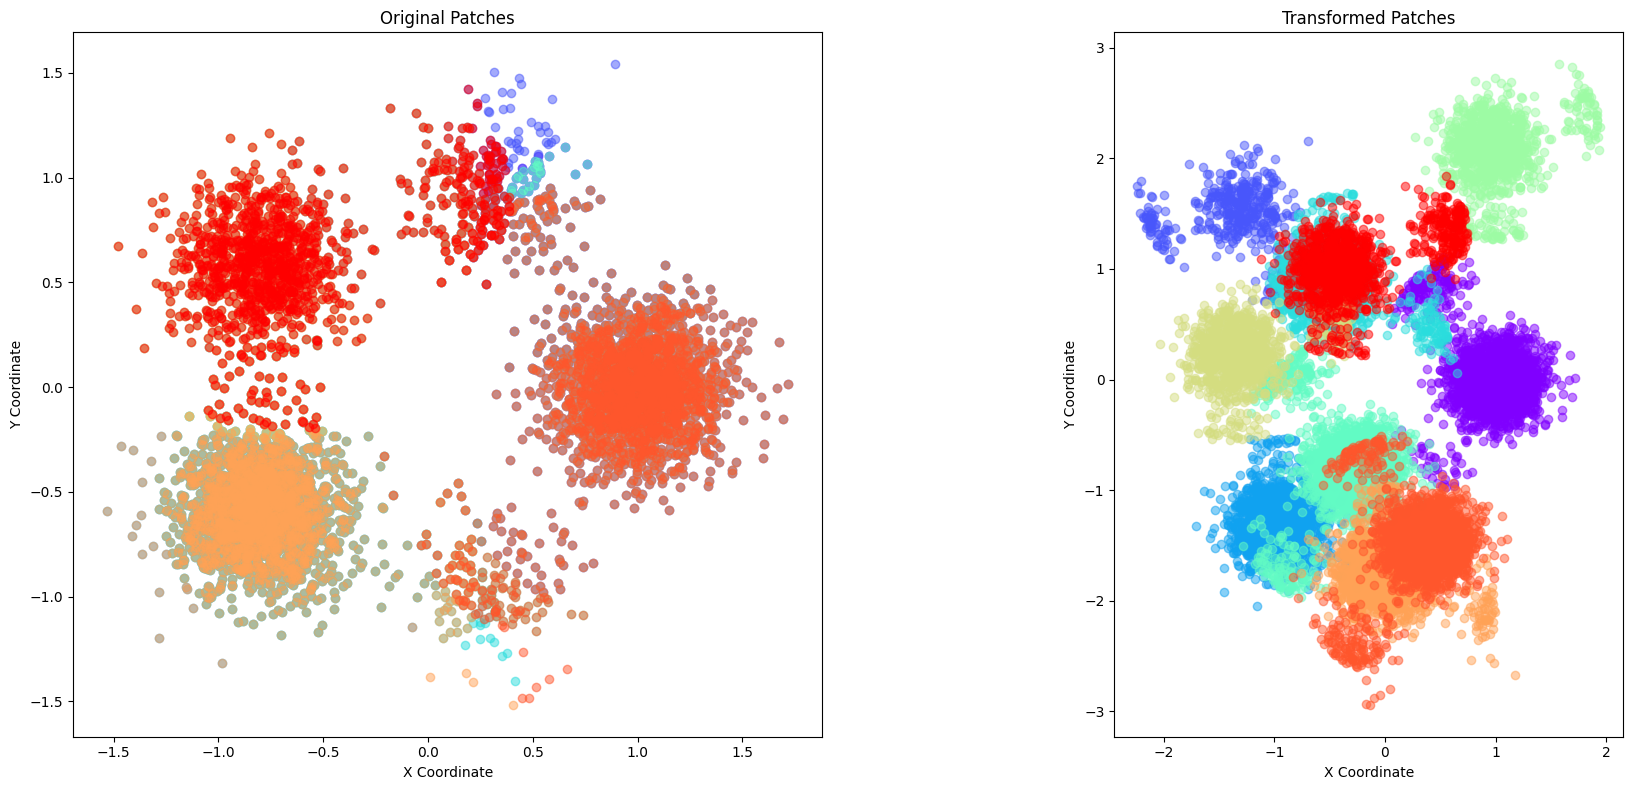

In [ ]:
geo_aligner = get_aligner(
    "geo",
    num_epochs=1000,
    learning_rate=0.01,
    model_type="affine",
    use_orthogonal_reg=False,
    verbose=True)
geo_aligner.align_patches(transformed_patches, min_overlap=64, scale=True)
embedding = geo_aligner.get_aligned_embedding()
plot_patches(patches, geo_aligner.patches)

In [179]:
geo_aligner.check_overlap_statistics()

=== Overlap Statistics ===
Total overlaps found: 45 (expected: 45)
Overlap coverage: 100.00%
Overlap sizes: min=0, max=1509, mean=198.3
Minimum required overlap: 64
⚠️  WARNING: Some overlaps are below minimum threshold!

=== Alignment Quality ===
No alignment quality data available (model not trained yet?)


{'total_overlaps': 45,
 'overlap_sizes': [9,
  549,
  0,
  0,
  64,
  0,
  10,
  387,
  295,
  0,
  133,
  0,
  1509,
  1499,
  64,
  0,
  0,
  16,
  64,
  0,
  0,
  64,
  555,
  215,
  97,
  64,
  133,
  629,
  12,
  0,
  0,
  0,
  133,
  230,
  122,
  1436,
  8,
  0,
  0,
  64,
  0,
  0,
  39,
  0,
  525],
 'min_overlap': 0,
 'max_overlap': 1509,
 'mean_overlap': 198.33333333333334,
 'overlap_coverage': 1.0,
 'alignment_quality': {}}

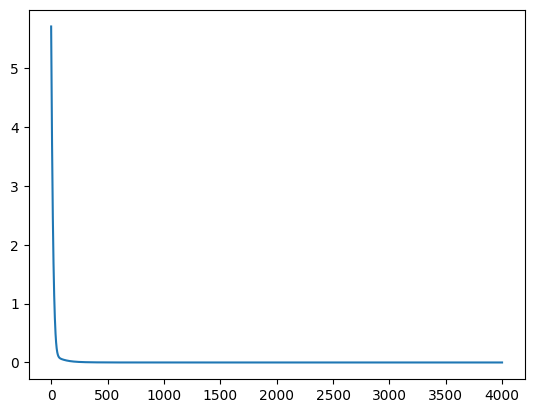

In [180]:
plt.plot(geo_aligner.loss_hist)
plt.show()

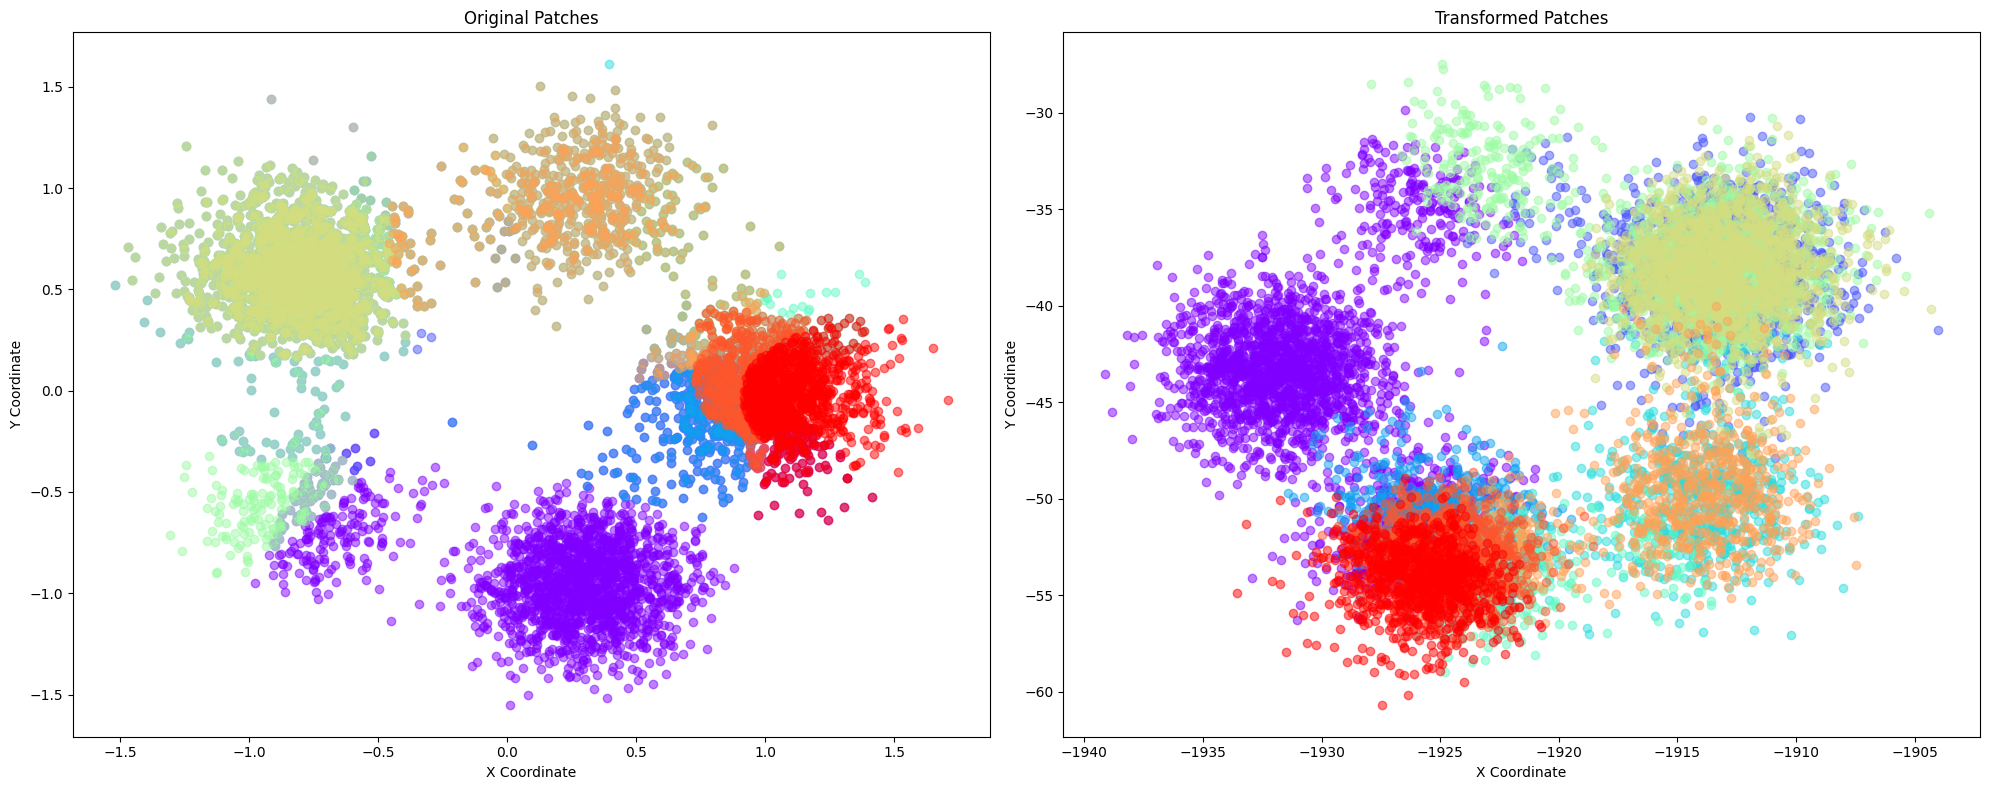

In [110]:
l2g_aligner = get_aligner("l2g")
l2g_aligner.align_patches(transformed_patches, scale=True)
embedding = l2g_aligner.get_aligned_embedding()
plot_patches(patches, l2g_aligner.patches)

In [115]:
procrustes_error(points, embedding)

np.float64(0.012058120733313771)

###  <a id='chapter7'> <font color="grey">7. Hierarchical alignment </font></a>

To be done.

###  <a id='chapter8'> <font color="grey">8. Visualisation </font></a>

For the visualisation, it is convenient to use external packages such as Heimdall.